In [8]:
import chess
import chess.pgn
import chess.svg
from IPython.display import display, clear_output
import time
from my_engine import get_best_move


In [9]:

board = chess.Board()
AI_DEPTH = 3


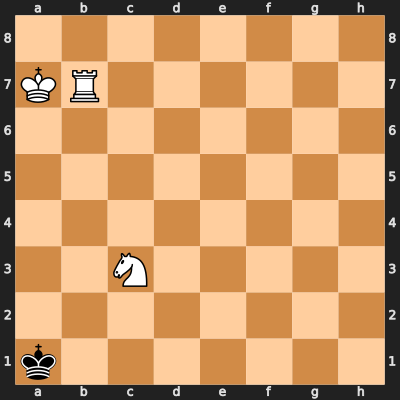

Outcome: Outcome(termination=<Termination.STALEMATE: 2>, winner=None)

time taken -4.647125699993921 PGN Output:
[Event "AI vs AI"]
[Site "Local"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "1/2-1/2"]

1. b4 d5 2. h4 h6 3. a4 Qd6 4. e4 Be6 5. b5 Qf4 6. Bc4 a5 7. Qg4 Bxg4 8. Nh3 Qf5 9. c3 Qc8 10. Bxd5 Qf5 11. Nf4 Na6 12. Kf1 Qd7 13. h5 Be2+ 14. Kg1 Bd1 15. Ba2 Qxd2 16. g3 Qd6 17. Bxf7+ Kd7 18. Be6+ Qxe6 19. b6 Rd8 20. Nd5 Kd6 21. Nd2 Kc5 22. f3 Nb4 23. Kf1 Re8 24. Kf2 Qh3 25. Nf6 Qd7 26. Ke3 Rb8 27. Nb3+ Kxb6 28. f4 c5 29. Nh7 g5 30. Ba3 Qxa4 31. Rc1 g4 32. Nd2 Rc8 33. Nb3 Qb5 34. Rh2 Qf1 35. Bxb4 axb4 36. Ng5 Qb5 37. Rb1 Bc2 38. Rhh1 Rc7 39. Nc1 Ka7 40. Nf3 Bxe4 41. Rh4 Kb8 42. Rh3 Qe2+ 43. Nxe2 c4 44. Kd4 b5 45. Rb2 e6 46. Rxb4 Rc5 47. Ng5 Rf5 48. Rxb5+ Bb7 49. Kxc4 Rd5 50. Ne4 gxh3 51. g4 Rf5 52. g5 Nf6 53. Kb3 Rxf4 54. Nd4 Bg7 55. Re5 Rc8 56. Nf2 Rg8 57. Rc5 Bf8 58. gxh6 Rfg4 59. Ne4 Nd5 60. Nf2 Ka7 61. Ka2 R4g6 62. Nxh3 Nb4+ 63. Ka1 Rg5 64. Nxg5 Rg6 65. Nh3 Nd3

In [11]:
game = chess.pgn.Game()
game.headers["Event"] = "AI vs AI"
game.headers["Site"] = "Local"
node = game 

start_time = time.perf_counter()
# FIX 1: Pass claim_draw=True to stop on 3-fold repetition or 50-move rule
while not board.is_game_over(claim_draw=True):
    time.sleep(0.01)
    if board.turn == chess.WHITE:
        move = get_best_move(board, AI_DEPTH)
    else:
        move = get_best_move(board, AI_DEPTH)

    board.push(move)
    node = node.add_variation(move)

    # Visualization
    clear_output(wait=True)
    display(chess.svg.board(board, size=400))

end_time = time.perf_counter()

result = board.result(claim_draw=True)
game.headers["Result"] = result
print(f"Outcome: {board.outcome(claim_draw=True)}") 

print(f"\ntime taken {start_time-end_time} PGN Output:")
print(game)
board.reset_board()